In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import numpy as np
from hmmlearn import hmm
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Ruta al archivo CSV
csv_path = "/home/mazroj/Chaos-Coders/coffee.csv"  # Reemplaza con la ruta a tu archivo CSV
test_size = 0.3  # Porcentaje de datos para el conjunto de prueba

try:
    # Usa pandas para leer el archivo CSV
    used_data = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Archivo CSV no encontrado. Por favor, verifica la ruta del archivo.")
    sys.exit()

In [3]:
def predictor(used_data, test_size, n_components,spaces):
    # No mezcles los datos ya que es una serie temporal
    _train_data, test_data = train_test_split(used_data, test_size=test_size, shuffle=False)

    # Elimina las columnas que no se usan
    train_data = _train_data.drop(["Volume", "Adj Close"], axis=1)  # Ajusta los nombres de las columnas según tu dataset
    test_data = test_data.drop(["Volume", "Adj Close"], axis=1)  # Ajusta los nombres de las columnas según tu dataset

    # Establece el atributo days
    days = len(test_data)

    # Extrae las características: precios de apertura, cierre, máximo y mínimo
    open_price = np.array(train_data["Open"])
    close_price = np.array(train_data["Close"])
    high_price = np.array(train_data["High"])
    low_price = np.array(train_data["Low"])

    # Calcula los cambios fraccionales en los precios alto, bajo y de cierre para usar como conjunto de observaciones
    frac_change = (close_price - open_price) / open_price
    frac_high = (high_price - open_price) / open_price
    frac_low = (open_price - low_price) / open_price

    # Apila las características en columnas
    features = np.column_stack((frac_change, frac_high, frac_low))

    # Inicializa el modelo HMM
    #n_components = 3  # Número de estados en el modelo, ajusta según tus necesidades
    hmm_1 = hmm.GMMHMM(n_components=n_components)

    # Registro de la extracción de características
    #_logger.info(">>> Extracting Features"3
    observations = features  # Usa las características que has calculado
    #_logger.info("Features extraction Completed <<<")

    # Ajusta el modelo HMM usando la función 'fit' de hmmlearn
    hmm_1.fit(observations)

    # Parámetros para los intervalos
    #spaces = 10
    n_intervals_frac_change = spaces  # Ajusta según tus necesidades
    n_intervals_frac_high = spaces  # Ajusta según tus necesidades
    n_intervals_frac_low = spaces  # Ajusta según tus necesidades

    # Crea arrays de NumPy con números espaciados uniformemente para cada rango
    frac_change_range = np.linspace(-0.1, 0.1, n_intervals_frac_change)
    frac_high_range = np.linspace(0, 0.1, n_intervals_frac_high)
    frac_low_range = np.linspace(0, 0.1, n_intervals_frac_low)

    # Calcula todos los resultados posibles utilizando el producto cartesiano
    possible_outcomes = np.array(
        list(itertools.product(frac_change_range, frac_high_range, frac_low_range))
    )

    # Parámetros
    day_index = 20  # Índice del día actual, ajusta según tus necesidades
    n_latency_days = 2  # Número de días de latencia, ajusta según tus necesidades

    # Usa los datos anteriores de n_latency_days para las predicciones
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_start_index:previous_data_end_index]

    # Supongamos que 'features' son las características extraídas
    # features = np.column_stack((frac_change, frac_high, frac_low))  # Descomenta esta línea si necesitas calcular las características
    previous_data_features = features  # Usa las características que has calculado

    outcome_score = []

    # Evalúa todos los resultados posibles y selecciona el más probable para usar en la predicción
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((previous_data_features, possible_outcome))
        outcome_score.append(hmm_1.score(total_data))

    # Obtén el índice del resultado más probable y devuélvelo
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    # Parámetros
    day_index_1 = len(test_data)-1 # Índice del día para el que quieres hacer la predicción, ajusta según tus necesidades

    # Obtén el precio de apertura para el día dado
    open_price = test_data.iloc[day_index_1]["Open"]

    # Supongamos que 'most_probable_outcome' contiene los cambios fraccionales más probables en [frac_change, frac_high, frac_low]
    predicted_frac_change, pred_frac_high, pred_frac_low = most_probable_outcome

    # Calcula el precio de cierre previsto
    predicted_close_price = open_price * (1 + predicted_frac_change)

    print(predicted_close_price)

    # Obtén la fecha correspondiente al day_index
    date_at_day_index = test_data.iloc[day_index_1]['Date']  # Reemplaza 'Fecha' con el nombre de tu columna de fechas
    print(date_at_day_index)

    return most_probable_outcome

In [8]:
data_change = used_data.copy()
data_change['Change'] = (used_data["Close"] - used_data['Open'])/used_data["Open"]
data_change

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,2022-10-21,188.699997,192.550003,186.199997,190.899994,190.899994,17813,0.011659
1,2022-10-24,190.050003,194.149994,188.899994,190.399994,190.399994,18487,0.001842
2,2022-10-25,191.100006,192.800003,183.300003,185.800003,185.800003,28943,-0.027734
3,2022-10-26,184.899994,185.750000,179.050003,179.750000,179.750000,25195,-0.027853
4,2022-10-27,181.000000,183.600006,178.100006,178.850006,178.850006,19567,-0.011878
...,...,...,...,...,...,...,...,...
246,2023-10-16,154.899994,156.149994,152.100006,154.149994,154.149994,24903,-0.004842
247,2023-10-17,154.000000,157.949997,152.449997,157.050003,157.050003,26996,0.019805
248,2023-10-18,157.149994,159.500000,156.649994,158.050003,158.050003,25576,0.005727
249,2023-10-19,158.149994,164.399994,158.149994,163.949997,163.949997,36623,0.036674


In [18]:
data_change.sort_values('Change')

,Date,Open,High,Low,Close,Adj Close,Volume,Change
17,2022-11-15,166.149994,167.699997,154.100006,156.750000,156.750000,12892,-0.056575
5,2022-10-28,178.850006,179.649994,167.750000,169.800003,169.800003,30554,-0.050601
9,2022-11-03,181.149994,181.250000,170.000000,172.199997,172.199997,23035,-0.049407
164,2023-06-20,185.100006,185.750000,176.399994,177.449997,177.449997,11003,-0.041329
202,2023-08-14,157.500000,158.300003,150.699997,151.100006,151.100006,21142,-0.040635
...,...,...,...,...,...,...,...,...
81,2023-02-17,180.850006,189.850006,179.949997,188.699997,188.699997,315,0.043406
157,2023-06-08,186.199997,196.149994,184.600006,194.850006,194.850006,34152,0.046455
96,2023-03-13,175.000000,183.699997,175.000000,183.199997,183.199997,2,0.046857
35,2022-12-12,156.300003,156.500000,155.000000,166.350006,166.350006,20,0.064299


In [21]:
datw = pd.read_csv("coffee_weekly.csv")


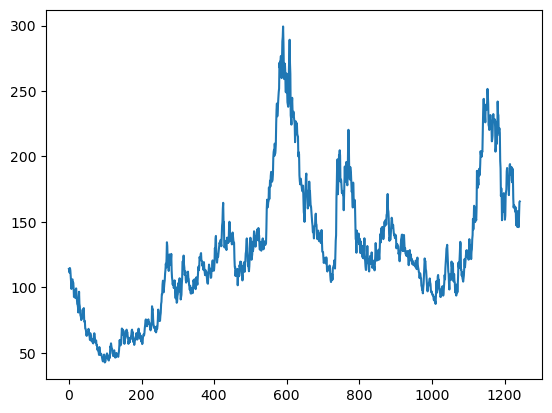

In [22]:
plt.plot(datw['Close'])